# Muon - Electron ECal Signatures
Trying to find a good discriminator for muons in the ECal.

## Input - MC Take 1

The MC was generated at JLab using the particle_trainer code, <span>`particle-trainer --part 6 -n 50000 muonsm_{sequence_num}.stdhep`</span>.
 A total of 5000 such jobs were run for mu- and mu+, for a total of 250M muons each. The resulting files were combined in a batch of 1000 files, resulting in 5 root files with 50M input events each. The total of 250M input events results in only 0.63M muons that caused a triggered event in HPS.
The distribution of muons is flat in momentum from 0.01 to 4.6 GeV, and flat in the x and y over the ECal.

The electrons were produced in a similar manner.


## Input - MC Take 2
The generator was modified to rotate all the output particles (i.e. rotate the beam) by 30.5 mrad. On Jul 5 2023 I ran 21 files of 100k
 events (sequence 0000 through 0020) and 20 files of 500k events (0021 - 0041) through the batch system at JLab. This time I saved the stdhep file. Note that these stdhep files are larger than the output. This new set is named <span>`mum_{i}.stdhep.root`</span> and <span>`mum_{i}_slic_recon.root`</span>.


In [1]:
import sys
sys.path.append("../Python")
import ROOT as R
%jsroot off
R.EnableImplicitMT()

from root_helpers import fancy_plot

import os
recompile = True
try:
    if os.path.getmtime('../Python/Utility_Functions_C.so') - os.path.getmtime('../Python/Utility_Functions.C') > 0:
        recompile = False
        print("Recompile is not needed")
    else:
        print("Recompiling: ")
except:
    print("Recompile needed, file not found.")
if recompile:
    R.gROOT.LoadMacro("../Python/Utility_Functions.C++")
else:
    R.gSystem.Load("../Python/Utility_Functions_C.so")
R.Utility_Functions()
R.gSystem.Load("../ECAL/lib/libEcal_Analysis")
R.gInterpreter.ProcessLine('''auto EAC = Ecal_Analysis_Class();''')   # This is key. It puts the EAC in C++ space.
print(f"Ecal Lib version: {R.EAC.Version()}")

Welcome to JupyROOT 6.29/01
Recompile is not needed
Ecal Lib version: V1.0.8


In [2]:
ch_mum = R.TChain("MiniDST")
ch_mum.Add("/data/HPS/data/MC/mum_2019/mum_*_slic_recon.root")
ch_ele = R.TChain("MiniDST")
ch_ele.Add("/data/HPS/data/MC/ele_2019/ele*.root")
N_mum = ch_mum.GetEntries()
N_ele = ch_ele.GetEntries()
print(f"N muon = {N_mum/1e6:5.2f} M  N ele = {N_ele/1e6:5.2f} M")
df_mum = R.RDataFrame(ch_mum)
df_ele = R.RDataFrame(ch_ele)
print("Available data names in Tuple:")
ColumnNames=df_mum.GetColumnNames()
ll = 0
pr_colnames = [x for x in ColumnNames if str(x).startswith('')]
for nn in pr_colnames:
    if ll < len(nn):
        ll = len(nn)
for n in range(len(pr_colnames)):
    if n%4 == 0:
        print("")
    print(f"{str(pr_colnames[n]):{ll}s}",end="")

N muon =  0.02 M  N ele =  9.01 M
Available data names in Tuple:

ecal_cluster_energy           ecal_cluster_hits             ecal_cluster_nhits            ecal_cluster_seed_energy      
ecal_cluster_seed_index       ecal_cluster_seed_ix          ecal_cluster_seed_iy          ecal_cluster_time             
ecal_cluster_uncor_energy     ecal_cluster_uncor_hits       ecal_cluster_uncor_nhits      ecal_cluster_uncor_seed_energy
ecal_cluster_uncor_seed_index ecal_cluster_uncor_seed_ix    ecal_cluster_uncor_seed_iy    ecal_cluster_uncor_time       
ecal_cluster_uncor_x          ecal_cluster_uncor_y          ecal_cluster_uncor_z          ecal_cluster_x                
ecal_cluster_y                ecal_cluster_z                ecal_hit_energy               ecal_hit_index_x              
ecal_hit_index_y              ecal_hit_time                 ecal_hit_x                    ecal_hit_y                    
ecal_hit_z                    event_number                  ext_trigger                

In [8]:
df_stdhep = R.RDataFrame("StdHep","/data/HPS/data/MC/mum_2019/mum_0000_stdhep.root")
df_stdhep.GetColumnNames()

vector<string>{ "energy", "mass", "pdg", "px", "py", "pz", "vx", "vy", "vz" }

In [3]:
# Define 2D histograms for the cluster seeds. The size is correct for "pretty printing".
h_m_ecal = df_mum.Histo2D(("m_hist_ecal","Ecal Seed Hits;ix;iy",50,-25.5,24.5,13,-6.5,6.5), "ecal_cluster_seed_ix", "ecal_cluster_seed_iy")
h_e_ecal = df_ele.Histo2D(("e_hist_ecal","Ecal Seed Hits;ix;iy",50,-25.5,24.5,13,-6.5,6.5), "ecal_cluster_seed_ix", "ecal_cluster_seed_iy")

# Define a fiducial cut. If any cluster seed is outside the cut, the whole event is skipped.
df_mum_fid = df_mum.Define("fiducial_cut","auto f=fiducial_cut(ecal_cluster_seed_ix,ecal_cluster_seed_iy); return f;").Filter("for(auto fid: fiducial_cut){ if(!fid){return(false);}}; return true;")
df_ele_fid = df_ele.Define("fiducial_cut","auto f=fiducial_cut(ecal_cluster_seed_ix,ecal_cluster_seed_iy); return f;").Filter("for(auto fid: fiducial_cut){ if(!fid){return(false);}}; return true;")

h_m_ecal_fid = df_mum_fid.Histo2D(("m_hist_ecal","Ecal Seed Hits;ix;iy",50,-25.5,24.5,13,-6.5,6.5), "ecal_cluster_seed_ix", "ecal_cluster_seed_iy")
h_e_ecal_fid = df_ele_fid.Histo2D(("e_hist_ecal","Ecal Seed Hits;ix;iy",50,-25.5,24.5,13,-6.5,6.5), "ecal_cluster_seed_ix", "ecal_cluster_seed_iy")

h_m_nclus = df_mum.Define("n","ecal_cluster_energy.size()").Histo1D(("h_m_nclus","N clusters",11,-0.5,10.5),"n")
h_e_nclus = df_ele.Define("n","ecal_cluster_energy.size()").Histo1D(("h_e_nclus","N clusters",11,-0.5,10.5),"n")
h_m_nhits = df_mum.Histo1D(("h_m_nhits","Muon N hits;N",25,-0.5,24.5),"ecal_cluster_nhits")
h_e_nhits = df_ele.Histo1D(("h_e_nhits","Muon N hits;N",25,-0.5,24.5),"ecal_cluster_nhits")
h_m_clus_e = df_mum.Histo1D(("h_m_clus_e","Ecal Cluster Energy, muons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_energy")
h_e_clus_e = df_ele.Histo1D(("h_e_clus_e","Ecal Cluster Energy, electrons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_energy")
h_m_clus_se = df_mum.Histo1D(("h_m_clus_se","Ecal Cluster Seed Energy, muons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_seed_energy")
h_e_clus_se = df_ele.Histo1D(("h_e_clus_se","Ecal Cluster Seed Energy, electrons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_seed_energy")
df12_mum = df_mum.Filter("ecal_cluster_nhits.size()==1 && ecal_cluster_nhits[0]<=2")
df12_ele = df_ele.Filter("ecal_cluster_nhits.size()==1 && ecal_cluster_nhits[0]<=2")
h12_m_clus_e = df12_mum.Histo1D(("h12_m_clus_e","Ecal Cluster Energy, muons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_energy")
h12_e_clus_e = df12_ele.Histo1D(("h12_e_clus_e","Ecal Cluster Energy, electrons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_energy")
h12_m_clus_se = df12_mum.Histo1D(("h12_m_clus_se","Ecal Cluster Seed Energy, muons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_seed_energy")
h12_e_clus_se = df12_ele.Histo1D(("h12_e_clus_se","Ecal Cluster Seed Energy, electrons;E [GeV]", 1000,-0.5,5.5),"ecal_cluster_seed_energy")

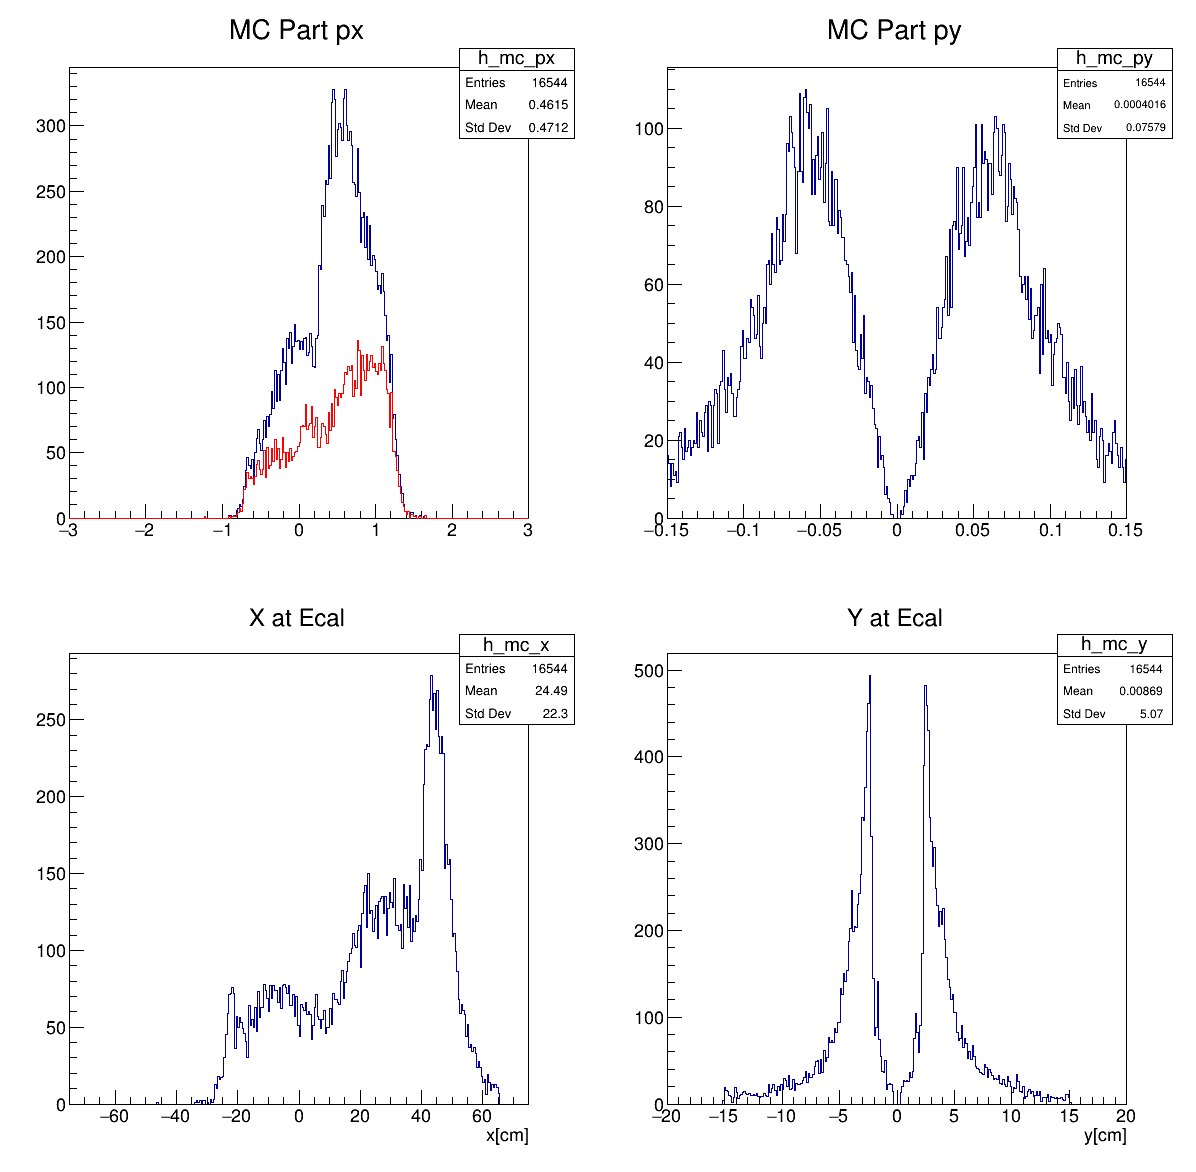

In [4]:
# Define the x,y,z component of the momentum for primary MC particles.
df_mum_tmp = df_mum.Define("mc_px","""
vector<double> out;
auto idx= get_list_of_primary_mc(mc_part_sim_status);
for(auto i: idx){out.push_back(mc_part_px[i]);}
 return out;""").Define("mc_py","""
vector<double> out;
auto idx= get_list_of_primary_mc(mc_part_sim_status);
for(auto i: idx){out.push_back(mc_part_py[i]);}
 return out;""").Define("mc_pz","""
vector<double> out;
auto idx= get_list_of_primary_mc(mc_part_sim_status);
for(auto i: idx){out.push_back(mc_part_pz[i]);}
 return out;""")
h_mc_px = df_mum_tmp.Histo1D(("h_mc_px","MC Part px",300,-3.,3.),"mc_px")
h_mc_px_c = df_mum_tmp.Define("mc_px_c","vector<double> out; for(int i=0; i<mc_px.size(); ++i){if(abs(mc_py[i])>0.075){out.push_back(mc_px[i]);}}; return out;").Histo1D(("h_mc_px_c","MC Part px cut on py",300,-3.,3.),"mc_px_c")
h_mc_x = df_mum_tmp.Define("x","vector<double> out; for(int i=0; i<mc_pz.size(); ++i){ out.push_back(150*mc_px[i]/mc_pz[i]);}; return out;").Histo1D(("h_mc_x","X at Ecal;x[cm]",300, -75., 75.),"x")
h_mc_y = df_mum_tmp.Define("y","vector<double> out; for(int i=0; i<mc_pz.size(); ++i){ out.push_back(150*mc_py[i]/mc_pz[i]);}; return out;").Histo1D(("h_mc_y","Y at Ecal;y[cm]",300, -20., 20.),"y")
h_mc_py = df_mum_tmp.Histo1D(("h_mc_py","MC Part py",300,-0.15,0.15),"mc_py")
#
# As thrown
#
h_mc_px_stdhep = df_stdhep.Histo1D(("h_mc_px","MC Part px from stdhep.",300,-3.,3.),"px")
cc00 = R.TCanvas("cc00","CC00",1200, 1200)
cc00.Divide(2,2)
p1 = cc00.cd(1)
h_mc_px.Draw()
h_mc_px_c.SetLineColor(R.kRed)
h_mc_px_c.Draw("same")
p2 = cc00.cd(2)
h_mc_py.Draw()
p3 = cc00.cd(3)
h_mc_x.Draw()
p4 = cc00.cd(4)
h_mc_y.Draw()
cc00.Draw()

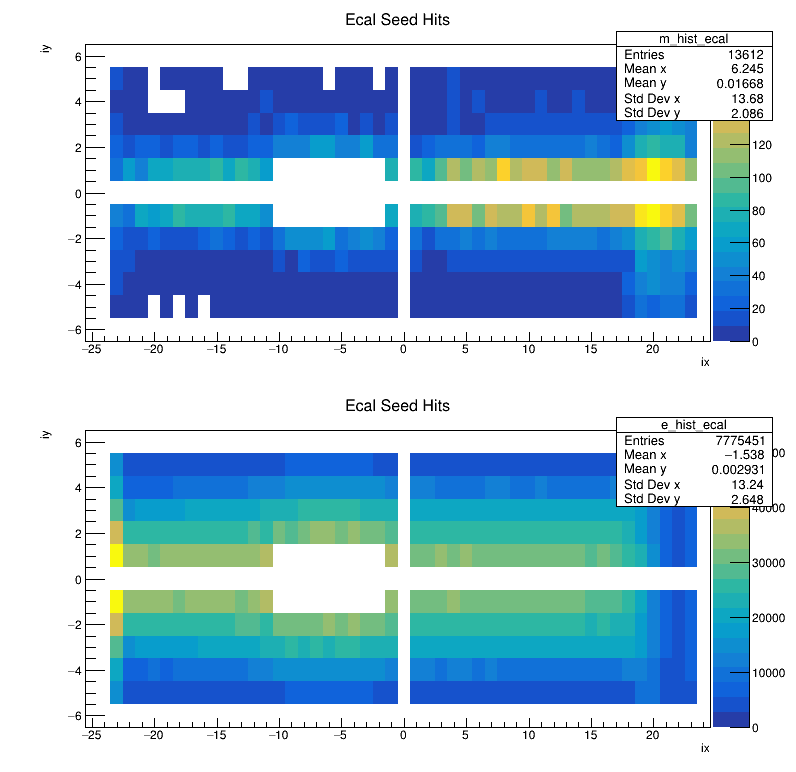

In [5]:
cc0 = R.TCanvas("cc0","CC0",800, 800)
cc0.Divide(1,2)
p1 = cc0.cd(1)
h_m_ecal.Draw("colz")
p2 = cc0.cd(2)
h_e_ecal.Draw("colz")
cc0.Draw()

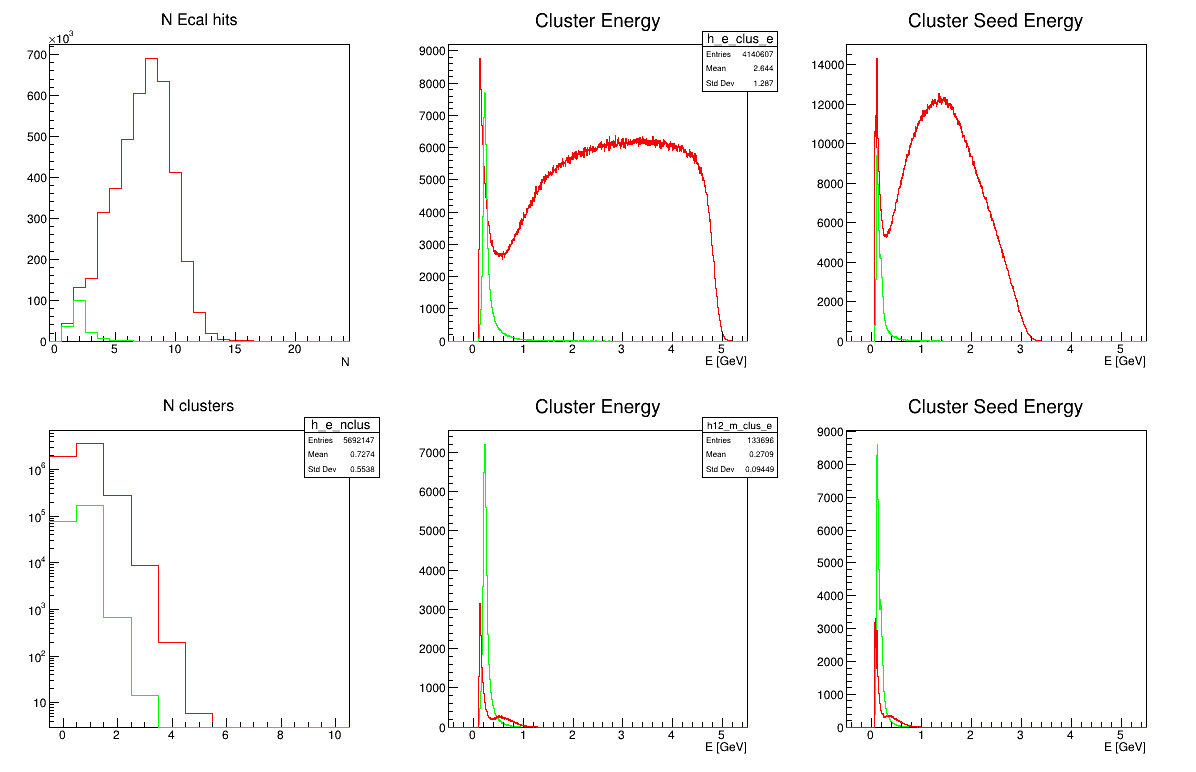

In [5]:
cc1 = R.TCanvas("cc1","CC1",1200, 800)
cc1.Divide(3,2)
p1 = cc1.cd(1)
p1.SetLogy(0)
h_e_nhits.SetTitle("N Ecal hits")
h_e_nhits.SetStats(0)
h_m_nhits.SetLineColor(R.kGreen)
h_e_nhits.SetLineColor(R.kRed)
h_e_nhits.Draw()
h_m_nhits.Draw("same")
p2 = cc1.cd(2)
p2.SetLogy(0)
# h_e_clus_e.SetStats(0)
h_e_clus_e.SetTitle("Cluster Energy")
h_m_clus_e.SetLineColor(R.kGreen)
h_e_clus_e.SetLineColor(R.kRed)
h_e_clus_e.Draw()
h_m_clus_e.Draw("same")
p3 = cc1.cd(3)
p3.SetLogy(0)
h_e_clus_se.SetStats(0)
h_e_clus_se.SetTitle("Cluster Seed Energy")
h_m_clus_se.SetLineColor(R.kGreen)
h_e_clus_se.SetLineColor(R.kRed)
h_e_clus_se.Draw()
h_m_clus_se.Draw("same")
p4 = cc1.cd(4)
p4.SetLogy(1)
h_m_nclus.SetLineColor(R.kGreen)
h_e_nclus.SetLineColor(R.kRed)
h_e_nclus.Draw()
h_m_nclus.Draw("same")
p5 = cc1.cd(5)
p5.SetLogy(0)
# h12_m_clus_e.SetStats(0)
h12_m_clus_e.SetTitle("Cluster Energy")
h12_m_clus_e.SetLineColor(R.kGreen)
h12_e_clus_e.SetLineColor(R.kRed)
h12_m_clus_e.Draw()
h12_e_clus_e.Draw("same")
p6 = cc1.cd(6)
p6.SetLogy(0)
h12_m_clus_se.SetStats(0)
h12_m_clus_se.SetTitle("Cluster Seed Energy")
h12_m_clus_se.SetLineColor(R.kGreen)
h12_e_clus_se.SetLineColor(R.kRed)
h12_m_clus_se.Draw()
h12_e_clus_se.Draw("same")
cc1.Draw()

In [6]:
one_hit_muon = h_m_nhits.GetBinContent(h_m_nhits.FindBin(1))
one_hit_electron = h_e_nhits.GetBinContent(h_e_nhits.FindBin(1))
print(f"Muon clusters with one hit: {one_hit_muon:7.0f}")
print(f"e-   clusters with one hit: {one_hit_electron:7.0f}")
print(f"Muon purity if selecting on one hit cluster: {100*(one_hit_muon/(one_hit_muon+one_hit_electron)):6.3f}%")
two_hit_muon = one_hit_muon + h_m_nhits.GetBinContent(h_m_nhits.FindBin(2))
two_hit_electron = one_hit_electron + h_e_nhits.GetBinContent(h_e_nhits.FindBin(2))
print(f"Muon clusters with 1 or 2 hits: {two_hit_muon:7.0f}")
print(f"e-   clusters with 1 or 2 hits: {two_hit_electron:7.0f}")
print(f"Muon purity if selecting on 1 or 2 hit cluster: {100*(two_hit_muon/(two_hit_muon+two_hit_electron)):6.3f}%")

Muon clusters with one hit:   35306
e-   clusters with one hit:   43599
Muon purity if selecting on one hit cluster: 44.745%
Muon clusters with 1 or 2 hits:  134487
e-   clusters with 1 or 2 hits:  174436
Muon purity if selecting on 1 or 2 hit cluster: 43.534%


In [7]:
dfx_mum = df_mum \
    .Define("one_crystal_e","RVec<double> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){ if(ecal_cluster_nhits[i]==1){ out.push_back(ecal_cluster_energy[i]);} } return out;") \
    .Define("one_crystal_se","RVec<double> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){ if(ecal_cluster_nhits[i]==1){ out.push_back(ecal_cluster_seed_energy[i]);} } return out;") \
    .Define("one_crystal_ue","RVec<double> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){ if(ecal_cluster_nhits[i]==1){ out.push_back(ecal_cluster_uncor_energy[i]);} } return out;")
dfx_ele = df_ele.Filter("for(auto fid: fiducial_cut){ if(!fid){return(false);}}; return true;") \
    .Define("one_crystal_e","RVec<double> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){ if(ecal_cluster_nhits[i]==1){ out.push_back(ecal_cluster_energy[i]);} } return out;") \
    .Define("one_crystal_se","RVec<double> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){ if(ecal_cluster_nhits[i]==1){ out.push_back(ecal_cluster_seed_energy[i]);} } return out;") \
    .Define("one_crystal_ue","RVec<double> out; for(int i=0; i< ecal_cluster_nhits.size(); ++i){ if(ecal_cluster_nhits[i]==1){ out.push_back(ecal_cluster_uncor_energy[i]);} } return out;")

h_m_1c_e = dfx_mum.Histo1D(("h_m_1c_e","One crystal energy #mu-;E [GeV]",200,0.,.6),"one_crystal_e")
h_m_1c_se = dfx_mum.Histo1D(("h_m_1c_se","One crystal energy #mu-; E [GeV]",200,0.,.6),"one_crystal_se")
h_m_1c_ue = dfx_mum.Histo1D(("h_m_1c_ue","One crystal energy #mu-; E [GeV]",200,0.,.6),"one_crystal_ue")
h_e_1c_e = dfx_ele.Histo1D(("h_e_1c_e","One crystal energy, e-;E [GeV]",200,0.,.6),"one_crystal_e")
h_e_1c_se = dfx_ele.Histo1D(("h_e_1c_se","One crystal energy, e-; E [GeV]",200,0.,.6),"one_crystal_se")
h_e_1c_ue = dfx_ele.Histo1D(("h_e_1c_ue","One crystal energy, e-; E [GeV]",200,0.,.6),"one_crystal_ue")


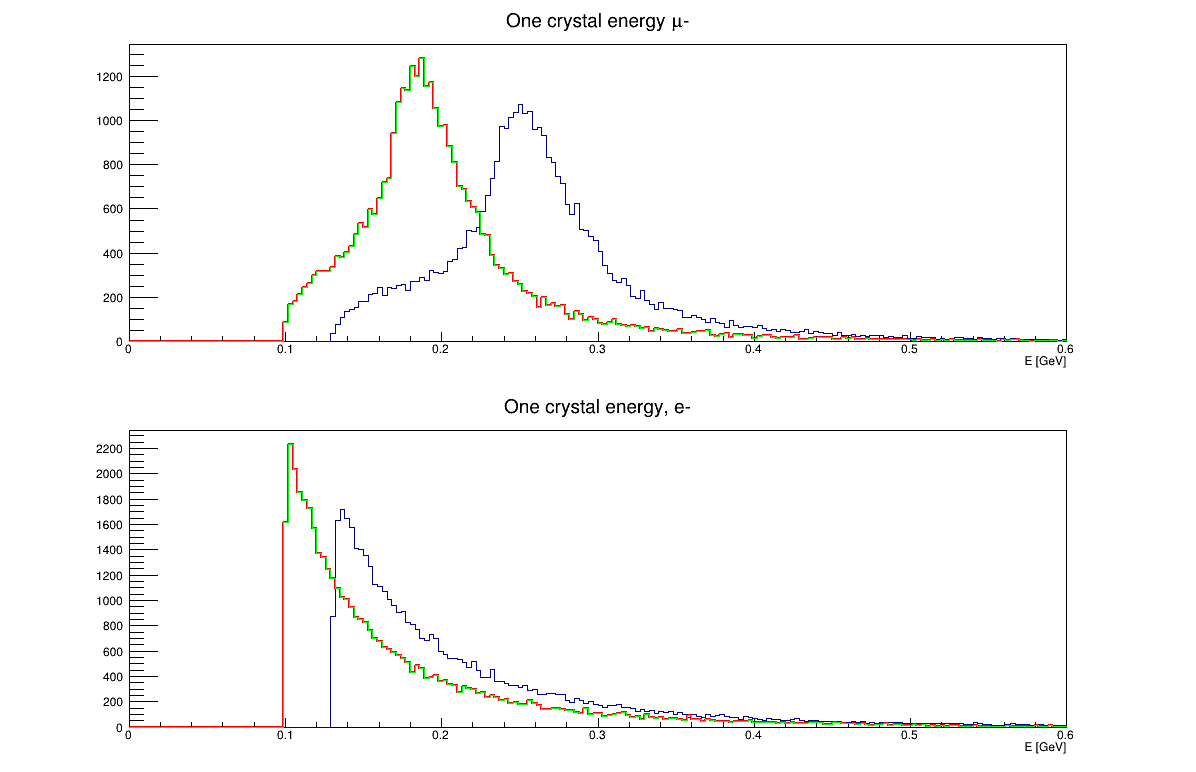

In [8]:
cc2 = R.TCanvas("cc2","CC2",1200, 800)
cc2.Divide(1,2)
p1 = cc2.cd(1)
h_m_1c_se.SetStats(0)
h_m_1c_se.SetLineColor(R.kRed)
h_m_1c_se.SetLineWidth(2)
h_m_1c_se.Draw()
h_m_1c_e.Draw("same")
h_m_1c_ue.SetLineColor(R.kGreen)
h_m_1c_ue.Draw("same")
p2 = cc2.cd(2)
h_e_1c_se.SetStats(0)
h_e_1c_se.SetLineColor(R.kRed)
h_e_1c_se.SetLineWidth(2)
h_e_1c_se.Draw()
h_e_1c_e.Draw("same")
h_e_1c_ue.SetLineColor(R.kGreen)
h_e_1c_ue.Draw("same")
cc2.Draw()